In [2]:
%pylab inline
import emcee
import hierarchical as hr
import plotutils.parameterizations as par
import plotutils.runner as pr
import scipy.optimize as so
import wl_likelihood as wl

Populating the interactive namespace from numpy and matplotlib


Choose some realistic parameters for the distribution of lens parameters:

In [3]:
mu = array([log(1e14), log(5)])
smm = square(log(3.0)) # Factor of 3 uncertainty in mass
scc = square(log(1.3)) # Factor of 1.3 uncertainty in c
smc = -0.5*sqrt(smm*scc) # Correlation coefficient of -0.5
sigma = array([[smm, smc], [smc, scc]])
sigma_params = par.cov_parameters(sigma)

Draw 50 true lens parameters from the distribution:

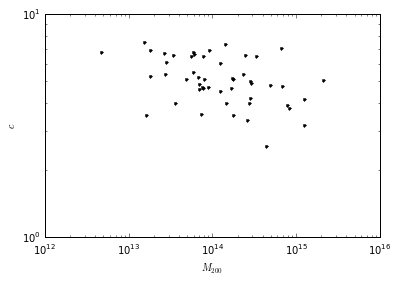

In [7]:
N = 50
true_lens_pars = multivariate_normal(mu, sigma, size=N)
true_zls = 0.3 + 0.1*randn(N)
true_zss = 1.0 + 0.1*randn(N)
loglog(exp(true_lens_pars[:,0]), exp(true_lens_pars[:,1]), '.k')
xlabel(r'$M_{200}$')
ylabel(r'$c$')

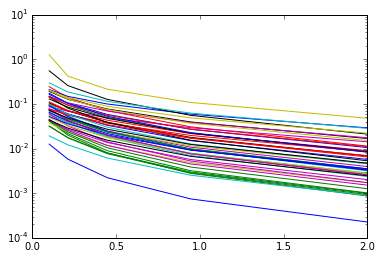

In [21]:
rs = exp(linspace(log(0.1), log(2), 5))
for i in range(N):
    plot(rs, wl.NFW(rs, exp(true_lens_pars[i,0]), exp(true_lens_pars[i,1]), true_zls[i], true_zss[i]))
yscale('log')

In [22]:
rs_data = []
data = []
sigmas = []
for i in range(N):
    shears = wl.NFW(rs, exp(true_lens_pars[i,0]), exp(true_lens_pars[i,1]), true_zls[i], true_zss[i])
    sigmas.append(lognormal(mean=log(0.01), sigma=log(2.0), size=shears.shape[0]))
    data.append(wl.WeakLensingLikelihood(rs, shears, sigmas[-1], true_zls[i], true_zss[i]).draw_data(true_lens_pars[i,:]))
    rs_data.append(rs)

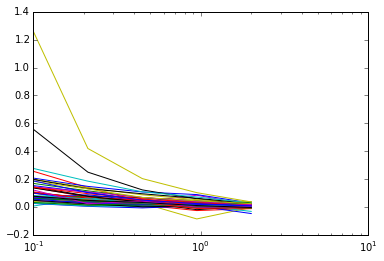

In [23]:
for r,d,s in zip(rs_data, data, sigmas):
    plot(r, d)
xscale('log')


In [24]:
logpost = hr.HierarchicalWLPosterior(rs_data, data, sigmas, true_zls, true_zss)
p0 = concatenate((mu, sigma_params, true_lens_pars.flatten()))
#pbest = so.fmin_powell(lambda x: -logpost(x), p0)
#pbest

In [ ]:
sampler = emcee.EnsembleSampler(256, p0.shape[0], logpost)
runner = pr.EnsembleSamplerRunner(sampler, p0+1e-4*randn(256, p0.shape[0]))
runner.run_to_neff(64, savedir='/tmp')